# Classification Demo

# Get Result

In [1]:
import cv2
import json
import requests
import urllib3

urllib3.disable_warnings()
s = requests.Session()
POWER_AI_VISION_API_URL = "https://p463a04.pbm.ihost.com/powerai-vision/api/dlapis/6952e5b4-35aa-45ae-b245-8769ad4e9c82"



def detect_objects(filename):

    with open(filename, 'rb') as f:
        # WARNING! verify=False is here to allow an untrusted cert!
        r = s.post(POWER_AI_VISION_API_URL,
                   files={'files': (filename, f)},
                   verify=False)

    return r.status_code, json.loads(r.text)

# Sample Frames from Video

In [2]:
import json
import glob
import math
import os
import shutil

import cv2
from IPython.display import clear_output, Image, display
import requests

FRAMES_DIR = "frames"  # Output dir to hold/cache the original frames
OUTPUT_DIR = "output"  # Output dir to hold the annotated frames
SAMPLING = 100  # Classify every n frames (use tracking in between)

input_video = "California.mp4"
print("Sampling every %sth frame" % SAMPLING)

if os.path.isfile(input_video):
    video_capture = cv2.VideoCapture(input_video)
else:
    raise Exception("File %s doesn't exist!" % input_video)

total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
stop_frame = total_frames-(total_frames%SAMPLING)-SAMPLING 
print("Frame count estimate is %d" % total_frames)
print("Stop at frame number",stop_frame )
if (total_frames %SAMPLING == 0):
    stop_frame = stop_frame-SAMPLING
FRAME_FPS = int(video_capture.get(cv2.CAP_PROP_FPS))
FRAME_WIDTH = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
FRAME_HEIGHT = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
ROI_YMAX = int(round(FRAME_HEIGHT * 0.75))

print("Frame Dimensions: %sx%s" % (FRAME_WIDTH, FRAME_HEIGHT))

files = glob.glob(FRAMES_DIR+"/*.jpg")
print("DELETING "+FRAMES_DIR+"/*.jpg")
for f in files:
    os.remove(f)

num = 0
#while video_capture.get(cv2.CAP_PROP_POS_FRAMES) < video_capture.get(cv2.CAP_PROP_FRAME_COUNT):
while num < stop_frame:
    success, image = video_capture.read()
    if success:
        num = int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))
#        print(num)
        if video_capture.get(cv2.CAP_PROP_POS_FRAMES) % SAMPLING == 0:  # Sample every Nth
            print("Writing frame {num} of {total_frames}".format(
            num=num, total_frames=stop_frame), end="\r")
            cv2.imwrite('{frames_dir}/frame_{num:05d}.jpg'.format(
            frames_dir=FRAMES_DIR, num=num), image)
    else:
        # TODO: If this happens, we need to add retry code
        raise Exception('Error writing frame_{num:05d}.jpg'.format(
        num=int(video_capture.get(cv2.CAP_PROP_POS_FRAMES))))

print("\nWrote {num} frames".format(num=num/SAMPLING), " to ",FRAMES_DIR, )



Sampling every 100th frame
Frame count estimate is 2153
Stop at frame number 2000
Frame Dimensions: 1920x1080
DELETING frames/*.jpg
Writing frame 2000 of 2000
Wrote 20.0 frames  to  frames


# Helper Functions

In [3]:
import cv2
import json
import requests
import json
import glob
import math
import os
import shutil
from IPython.display import clear_output, Image, display
import requests

WHITE = (255, 255, 255)
YELLOW = (66, 244, 238)
GREEN = (80, 220, 60)
LIGHT_CYAN = (255, 255, 224)
DARK_BLUE = (139, 0, 0)
GRAY = (128, 128, 128)

def classify_frames(result, filename):
    image = cv2.imread(filename)
    overlay = image.copy()
    fontface = cv2.FONT_HERSHEY_SIMPLEX
    fontscale = 1
    thickness = 1

    if 'classified' in result:
#        print("Got back %d objects" % len(jsonresp['classified']))
        obj = result['classified'] 
    for i in obj:
        hazard = obj.get("hazard", "")
        unkown = obj.get("_negative_","")
        clear = obj.get("clear", "")
        fontface = cv2.FONT_HERSHEY_SIMPLEX
        fontscale = 1
        thickness = 1
        if not (hazard =="") and (unkown==""):
#            print("Hazard")
            label = ("hazard "+"(%.2f"%(float(hazard)*100)+ "% )")
            cv2.rectangle(overlay,
                    (0, ROI_YMAX),
                    (FRAME_WIDTH, FRAME_HEIGHT), YELLOW, cv2.FILLED)    
        elif not (clear=="") and (unkown==""):
#            print("Clear")
            label = ("clear "+"(%.2f"%(float(clear)*100)+"% )")
            cv2.rectangle(overlay,
                    (0, ROI_YMAX),
                    (FRAME_WIDTH, FRAME_HEIGHT), GREEN, cv2.FILLED)    
        else:
#            print("Uncategorized")
            label= ("uncertain")
            cv2.rectangle(overlay,
                    (0, ROI_YMAX),
                    (FRAME_WIDTH, FRAME_HEIGHT), GRAY, cv2.FILLED)    


    # Shade region of interest (ROI). We're really just using the top line.
    alpha = 0.3
    cv2.addWeighted(overlay, alpha, image, 1-alpha, 0, image)
    cv2.putText(image, label, (30, ROI_YMAX + 80), fontface, 1.5, LIGHT_CYAN, 4, cv2.LINE_AA)

    filename_out = "output/output-" + filename.split('/')[1]
    cv2.imwrite(filename_out, image)

    output_image = cv2.imread(filename_out)
    #print("Reading",filename_out)
    clear_output(wait=True)
    output_image = cv2.resize(output_image, (int(FRAME_WIDTH/2), int(FRAME_HEIGHT/2)))  # shrink it
    _ret, jpg = cv2.imencode('.jpg', output_image)
    display(Image(data=jpg))            

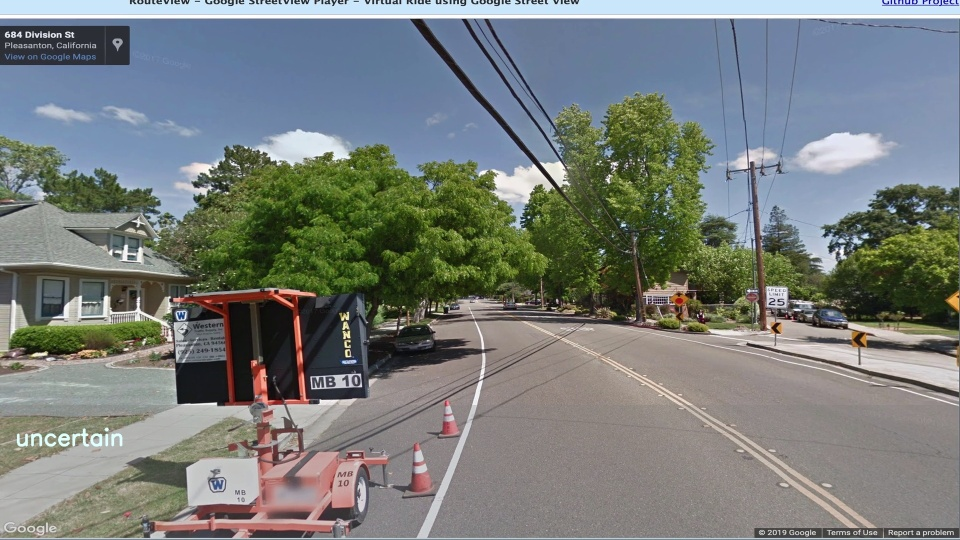


Done


In [4]:
i = 0

files = glob.glob("output/*.jpg")
print("DELETING "+"output/*.jpg")
for f in files:
    os.remove(f)

for filename in sorted(glob.glob('frames/frame_*.jpg')):
    i += 1
    rc, results = detect_objects(filename)
    classify_frames(results, filename)

print("\nDone")

## Create a video from the annotated frames

In [110]:
!ffmpeg -y -loglevel panic -framerate 1 -pattern_type glob -i 'output/*.jpg' -c:v libx264 -r 30 -pix_fmt yuv422p out.mp4

In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open('out.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))